# EPW workflow for polaron calculations

### $\underline{Introduction}$

In this notebook, we will perform calculations of self-trapped polarons in 2D materials with the EPW code. The methodology for polarons in 2D remains the same as in 3D, and one can review it in the notebook **polaron**. However, the dipole electron-phonon interactions have different long-range behaviors, which drastically change the polaron formation in atomistic thin 2D materials. The complete theory and computational method are described in [Phys. Rev. B **105**, 115414 (2022)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.105.115414) and [Nat. Phys. **19**, 629-636 (2023)](https://doi.org/10.1038/s41567-023-01953-4).

We quote the self-consistent polaron equations in reciprocal space here:
$$\begin{aligned}
  &\frac{2}{N_p} \sum_{\mathbf{q}m\nu} B_{\mathbf{q}\nu}
  \, g_{mn\nu}^{*}(\mathbf{k},\mathbf{q}) \, A_{m\mathbf{k+q}}
  =
  (\varepsilon_{n\mathbf{k}}-\varepsilon) A_{n\mathbf{k}} ~,\\
  &B_{\mathbf{q}\nu} = \frac{1}{N_p}
  \sum_{mn\mathbf{k}} A^{*}_{m\mathbf{k+q}}
  \frac{g_{mn\nu}(\mathbf{k},\mathbf{q})}{\hbar\omega_{\mathbf{q}\nu}} A_{n\mathbf{k}} ~.
\end{aligned}$$
where $g_{mn\nu}({\bf k},{\bf q})$ is the electron-phonon vertex that needs to be interpolated into finer grids when solving the equations. One can review them in the **polaron** notebook, or Eq.(37-38) in [Phys. Rev. B **99**, 235139 (2019)](https://doi.org/10.1103/PhysRevB.99.235139).

In bulk polaron materials, Frohlich (dipole) interaction is the key to form a large polaron, while it is divergent in the limit of $|{\bf q}|=0$, which cannot be captured using Fourier interpolation with finite Fourier components. To treat this problem, one could subtract and add the Frohlich vertex before and after the interpolation of $g_{mn\nu}({\bf k},{\bf q})$, by using the analytic expression shown as Eq.(4) in [Phys. Rev. Lett. 115, 176401 (2015)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.115.176401). In practice, one needs to set "lpolar" to ".true." in the "epw2" calculations. However, in monolayer polar materials, the finite thickness imposes screening to the long-range couplings. Based on the dielectric slab model, one could arrive at the Eq.(46) in [Phys. Rev. B **105**, 115414 (2022)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.105.115414) , which is used to interpolate the dipole part of electron-phonon vertex, when the input variable "system_2d" is set as "dipole_sh".

> Example performed below: hole polaron in monolayer hexagonal BeO.

### $\underline{Working~Environment}$

Load required modules:

In [10]:
import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt
import os
import pandas as pd
import sys
#dir_nb = str(os.getcwd())
dir_nb = '/scratch1/08220/kfluo/notebook_epw_bgw'
print(dir_nb)
sys.path.insert(0,dir_nb+'/EPWpy/')
from EPWpy import *
from plotting import plot_polaron

/scratch1/08220/kfluo/notebook_epw_bgw


Set paths to relevant directories:

In [11]:
# Set QE binaries directory
#QE='/work2/08220/kfluo/frontera/software/qe-7.3/bin/'
QE='/work2/08220/kfluo/frontera/software/qe-7.2-plrn/bin/'
print('Path to QE binaries:', QE)
# Set working directory
workdir='/scratch1/08220/kfluo/workdir/'
#
os.chdir(str(workdir))
print('Working directory:', workdir)
#
prefix='beo'
print('Material prefix:', prefix)
#
pseudo = dir_nb+'/pseudos/'
print('Directory of pseudopotentials:', pseudo)

Path to QE binaries: /work2/08220/kfluo/frontera/software/qe-7.2-plrn/bin/
Working directory: /scratch1/08220/kfluo/workdir/
Material prefix: beo
Directory of pseudopotentials: /scratch1/08220/kfluo/notebook_epw_bgw/pseudos/


Define general calculation parameters to be used throughout the workflow:

In [12]:
beo=EPWpy({'prefix':prefix,
           'restart_mode':'\'from_scratch\'',
           'calculation':'\'scf\'',
           'ibrav':4,
           'nat':2,
           'ntyp':2,
           'atomic_species':['Be', 'O'],
           'atomic_pos':np.array([[0.5, 0.2886751, 0.0], \
                                  [0.0, 0.5773503, 0.0]]), # in alat
           'mass':[9.3227, 13.6181],
           'atoms':['Be', 'O'],
           'pseudo':['Be.upf', 'O.upf'],
           'ecutwfc':'88',
           'ecutrho':'352',
           'celldm(1)':'5.0637',
           'celldm(3)':'5',
           'verbosity':'high',
           'pseudo_dir':'\''+str(pseudo)+'\''},
           code=QE,
           env='ibrun',
           system='beo')

# Print relevant info
pseudopot=beo.__dict__['default_pw_atomic_species']['pseudo'][0]
print('pseudopotential directory:', beo.__dict__['default_pw_control']['pseudo_dir'])
print('pseudopotential:', beo.__dict__['default_pw_atomic_species']['pseudo'][:])

                                       ``:oss/                                        
                           `.+s+.     .+ys--yh+     `./ss+.                           
                          -sh//yy+`   +yy   +yy    -+h+-oyy                           
                          -yh- .oyy/.-sh.   .syo-.:sy-  /yh                           
                 `.-.`    `yh+   -oyyyo.     `/syys:    oys      `.`                  
               `/+ssys+-` `sh+      `                   oys`   .:osyo`                
               -yh- ./syyooyo`                          .sys+/oyo--yh/                
               `yy+    .-:-.                             `-/+/:`  -sh-                
                /yh.                                              oys                 
          ``..---hho---------`   .---------..`      `.-----.`    -hd+---.             
       `./osmNMMMMMMMMMMMMMMMs. +NNMMMMMMMMNNmh+.   yNMMMMMNm-  oNMMMMMNmo++:`        
       +sy--/sdMMMhyyyyyyyNMMh- .oyNMMmyyyy

### $\underline{Workflow}$ 

#### $\underline{1.~Preliminary~calculations:~scf,~ph,~nscf}$

In [13]:
# Prepare scf input file
beo.scf(system={'assume_isolated':'2D'},
        electrons={'conv_thr':'1.0d-12'}, 
        kpoints={'kpoints':[[9, 9, 1]]}, 
        name='scf')
beo.prepare(56,type_run='scf')

scf


In [14]:
# Run scf calculation
beo.run(56)

['Be.upf', 'O.upf']
running scf with 56 k and 1 tasks
ibrun /work2/08220/kfluo/frontera/software/qe-7.2-plrn/bin//pw.x -nk 56 -nt 1 -input scf.in > scf.out


In [15]:
# Prepare ph input file
beo.ph(phonons={'fildyn':'\'beo.dyn\'',
                'nq1':3,'nq2':3,'nq3':1,
                'fildvscf':'\'dvscf\'',
                'nmix_ph':12,
                'tr2_ph':'1.0d-18',
                'reduce_io':'.true.',
                'epsil': '.true.',
                'zeu': '.true.'}) 
beo.prepare(56,type_run='ph')
# Run ph calculation
beo.run(56,type_run='ph')

running ph with 56 k and 1 tasks
ibrun /work2/08220/kfluo/frontera/software/qe-7.2-plrn/bin//ph.x -nk 56 -nt 1 -pd .true. -input ph.in > ph.out


In [17]:
# Prepare nscf input file
beo.nscf(system={'nbnd':5,
                 'assume_isolated':'\'2D\'',},
         kpoints={'grid':[9, 9, 1],
        'kpoints_type': 'crystal'})
beo.prepare(56, type_run='nscf')
# Run nscf calculation
beo.run(56,type_run='nscf')

nscf
running nscf with 56 k and 1 tasks
ibrun /work2/08220/kfluo/frontera/software/qe-7.2-plrn/bin//pw.x -nk 56 -nt 1 -input nscf.in > nscf.out | tail -f nscf.out


#### $\underline{2.~Calculating~g~matrix~on~coarse~grid}$

In [18]:
# Generate filkf if needed ## crystal
G=[0.0,    0.0,    0.0]
X=[0.5,    0.0,    0.0]
K=[0.3333, 0.3333, 0.0]
sympoints=[X,G,K]
#
beo.filkf(path=sympoints, length=[51, 51], name='path.kpt')

generating filkf


In [20]:
# Prepare epw input for coarse-grid calculation
beo.epw(epwin={'lpolar':'.true.',
               'epwwrite':'.true.',
               'epwread':'.false.',
               'epbwrite':'.false.',
               'system_2d': 'dipole_sh',
               'use_ws':'.false.',
               'asr_typ':'simple',
               'wannierize':'.true.',
               'auto_projections':'.true.',
               'scdm_proj':'.true.',
               'band_plot':'.true.',
               'filkf':'\'../path.kpt\'',
               'filqf':'\'../path.kpt\'',
               'nk1':9,'nk2':9,'nk3':1,
               'nq1':3,'nq2':3,'nq3':1,
               'num_iter':500,
               'nbndsub':3,
               'bands_skipped':'\'exclude_bands = 1:2\'',
               'wannier_plot':'.true.',
               'wannier_plot_supercell':'6 6 6'},
        name='epw1')
#
beo.prepare(56, type_run='epw1')
beo.run(56, type_run='epw1')

running epw with 56 k and 
ibrun /work2/08220/kfluo/frontera/software/qe-7.2-plrn/bin//epw.x -nk 56 -input epw1.in > epw1.out


#### $\underline{3.~Solving~polaron~equations~with~interpolated~g~matrix}$

In [27]:
# Prepare epw input for polaron calculation on fine-grid
beo.epw(epwin={'elph':'.true.',
               'epwread':'.true.',
               'epwwrite':'.false.',
               'epbwrite':'.false.',
               'lpolar':'.true.',
               'system_2d': 'dipole_sh',
               'wannierize':'.false.',
               'use_ws':'.false.',
               'asr_typ':'simple',
               'nbndsub':3,
               'bands_skipped':'\'exclude_bands = 1:2\'',
               'plrn':'.true.',
               'restart_plrn':'.false.',
               'type_plrn':1,
               'init_plrn':1,
               'init_sigma_plrn':1,
               'niter_plrn':500,
               'conv_thr_plrn':1.0E-4,
               'ethrdg_plrn':1.0E-6,
               'adapt_ethrdg_plrn':'.true.',
               'init_ethrdg_plrn':1.0E-3,
               'nk1':9, 'nk2':9, 'nk3':1,
               'nq1':3, 'nq2':3, 'nq3':1,
               'nkf1':10, 'nkf2':10, 'nkf3':1,
               'nqf1':10, 'nqf2':10, 'nqf3':1,
               'eps_acustic':1,
               'diago_david_ndim':4},
            name='epw2')
#
beo.prepare(56,type_run='epw2')
beo.run(56,type_run='epw2')

running epw with 56 k and 
ibrun /work2/08220/kfluo/frontera/software/qe-7.2-plrn/bin//epw.x -nk 56 -input epw2.in > epw2.out


#### $\underline{4.~Postprocessing:~A_{n{\bf k}}, B_{{\bf q}\nu}, \psi({\bf r})}$

In [28]:
beo.epw(epwin={'elph':'.true.',
               'epwread':'.true.',
               'epbwrite':'.false.',
               'lpolar':'.true.',
               'system_2d':'dipole_sh',
               'wannierize':'.false.',
               'nbndsub':3,
               'bands_skipped':'\'exclude_bands = 1:2\'',
               'plrn':'.true.',
               'restart_plrn':'.true.',
               'type_plrn':1,
               'cal_psir_plrn':'.false.', ## wavefunction in real space
               'step_wf_grid_plrn':4,
               'interp_Ank_plrn':'.true.',
               'interp_Bqu_plrn':'.true.',
               'filkf':'\'../path.kpt\'',
               'filqf':'\'../path.kpt\'',
               'nk1':9, 'nk2':9, 'nk3':1,
               'nq1':3, 'nq2':3, 'nq3':1,
               'eig_read':'.false.'},
            name='epw3')
#
beo.prepare(56,type_run='epw3')
beo.run(56,type_run='epw3')

running epw with 56 k and 
ibrun /work2/08220/kfluo/frontera/software/qe-7.2-plrn/bin//epw.x -nk 56 -input epw3.in > epw3.out


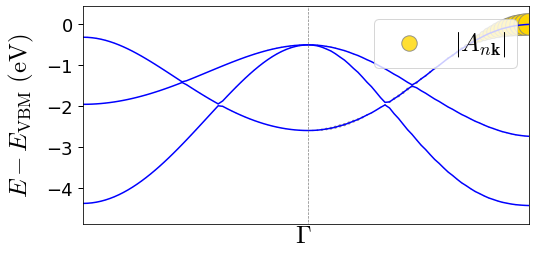

In [29]:
# Plot Ank coefficients
plot_polaron.plot_Ank_Bqv('Ank', 
                          workdir+prefix+'/path.kpt',
                          sympoints,
                          workdir+prefix+'/epw/Ank.band.plrn')

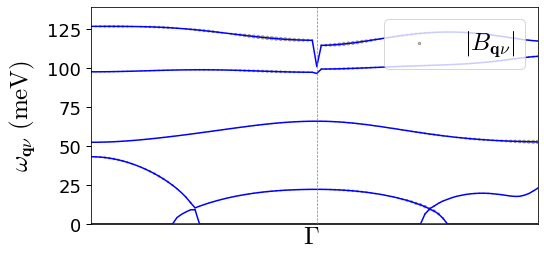

In [30]:
# Plot Bqv coefficients
plot_polaron.plot_Ank_Bqv('Bqv', 
                          workdir+prefix+'/path.kpt', 
                          sympoints, 
                          workdir+prefix+'/epw/Bmat.band.plrn')

<span style="color:red">FIXME: the aoucstic phonon dispersion is problematic, which was stable when I test monolayer BeO before. EPWpy may generate inputs slightly different from mine, while I haven't find it out.</span>

*OPTIONAL:* Plot wavefunction; needs installation of [VESTA](https://jp-minerals.org/vesta/en/) (TODO improve this, plot with python?)

#### $\underline{5.~Convergence:~Makov-Payne~extrapolation}$

In [33]:
# List of k-point meshes to consider
klist = [10, 15, 20]
# Generate input files
# Read original epw.in file for reference
origfile = workdir+prefix+'/epw2.in'
with open(origfile, 'rt') as f:
    data = f.readlines()
#
for k in klist:
    # set name and path for equilibrium supercell input files
    newfile = workdir+prefix+'/epw/epw.k'+str(k)+'.in'
    with open(newfile, 'w') as f: 
        for line in data :
            # Modify fine grid lines
            if( len(line.split())>0 ):
                if( line.split()[0] =='nkf1'):   
                    f.write('  nkf1 = '+str(k)+'\n')
                elif( line.split()[0] =='nkf2'):   
                    f.write('  nkf2 = '+str(k)+'\n')
                elif( line.split()[0] =='nkf3'):   
                    f.write('  nkf3 = '+str(1)+'\n')
                elif( line.split()[0] =='nqf1'):   
                    f.write('  nqf1 = '+str(k)+'\n')
                elif( line.split()[0] =='nqf2'):   
                    f.write('  nqf2 = '+str(k)+'\n')
                elif( line.split()[0] =='nqf3'):   
                    f.write('  nqf3 = '+str(1)+'\n')
                else:
                    f.write(line)

In [34]:
# Run calculations
for k in klist:
    beo.run(56, type_run='epw3', 
            infile=workdir+prefix+'/epw/epw.k'+str(k))

running epw with 56 k and 
ibrun /work2/08220/kfluo/frontera/software/qe-7.2-plrn/bin//epw.x -nk 56 -input /scratch1/08220/kfluo/workdir/beo/epw/epw.k10.in > /scratch1/08220/kfluo/workdir/beo/epw/epw.k10.out
running epw with 56 k and 
ibrun /work2/08220/kfluo/frontera/software/qe-7.2-plrn/bin//epw.x -nk 56 -input /scratch1/08220/kfluo/workdir/beo/epw/epw.k15.in > /scratch1/08220/kfluo/workdir/beo/epw/epw.k15.out
running epw with 56 k and 
ibrun /work2/08220/kfluo/frontera/software/qe-7.2-plrn/bin//epw.x -nk 56 -input /scratch1/08220/kfluo/workdir/beo/epw/epw.k20.in > /scratch1/08220/kfluo/workdir/beo/epw/epw.k20.out


[ 5.000e-07 -1.294e-04]


ValueError: x and y must be the same size

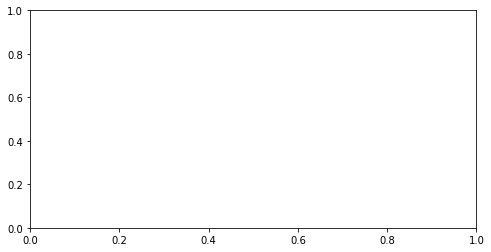

In [36]:
## Linear fit and extrapolate to Np->\infty
ucell_volume = 1 
## FIXME: needs to change ucell_volume to ucell_area for 2D
## or change the unit to be Energy per Unit cell
#
# Read formation energies from output files
Eform = []
for k in klist:
    outfile = workdir+prefix+'/epw/epw.k'+str(k)+'.out'
    with open(outfile, 'r') as f: 
        for line in f:
            if( len(line.split())>0 ):
                if( line.split()[0] =='Formation'):    
                    Eform.append(float(line.split()[3]))
#
Nk = np.array(klist)
Eform = np.array(Eform)
# Plot
plot_polaron.plot_EvsNk(ucell_volume, Nk, Eform)

In [37]:
<span style="color:red">FIXME: real solutions are NOT found due to the issue in phonon dispersions.</span>

SyntaxError: invalid syntax (<ipython-input-37-c2acb4f85c22>, line 1)

### $\underline{Exercises}$

1. Plot the polaron wavefunction isosurface with VESTA.
2. Look at the effective thickness calculated in the "epw2.out", then compare it with geometric thickness and polaron wavefunction along $z$-direction.
3. Calculate the electron polaron in the hexagonal monolayer BeO. Note: the conductance bands near band gap are entangaled, which needs precaution for wannierization.
4. Check out the limiting behavior of $g$ coupling matrix of electron and optical phonon modes, to reproduce Fig.5 (which is for h-BN) in [Phys. Rev. B **105**, 115414 (2022)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.105.115414) .